In [2]:
import numpy as np
import pandas as pd
from jupyter_events.cli import console
from scipy.stats import norm
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
import os
import seaborn as sns
from starlette.config import undefined

In [3]:
CATEGORIES = {
"Sex": ["M", "F"],
"ChestPainType": ["TA", "ATA", "NAP", "ASY"],
"RestingECG": ["Normal", "ST", "LVH"],
"ExerciseAngina": ["Y", "N"],
"ST_Slope": ["Up", "Flat", "Down"]
}


NUMERIC_COLUMNS = [
"Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"
]

In [4]:
def _build_correlation_matrix(d, rho):
    if d == 1:
        return np.array([[1.0]])
    M = np.full((d, d), rho)
    np.fill_diagonal(M, 1.0)
    return M



In [21]:

def generate_synthetic_data(
    n_samples=1000,
    independence=1.0,
    random_state=42,
    label_balance=0.5,
    max_rho=0.85,
    noise_sigma=undefined
):
    np.random.seed(random_state)

    # Generate labels
    n0 = int(n_samples * (1 - label_balance))
    n1 = n_samples - n0
    y = np.array([0]*n0 + [1]*n1)
    np.random.shuffle(y)

    # Class‑specific marginals (to make y informative)
    numeric_marginals = {
        0: {
            "Age": ("uniform", 20, 60),
            "RestingBP": ("uniform", 90, 150),
            "Cholesterol": ("uniform", 120, 300),
            "FastingBS": ("bernoulli", 0.1),
            "MaxHR": ("uniform", 80, 180),
            "Oldpeak": ("uniform", 0, 3)
        },
        1: {
            "Age": ("uniform", 40, 80),
            "RestingBP": ("uniform", 110, 180),
            "Cholesterol": ("uniform", 180, 350),
            "FastingBS": ("bernoulli", 0.3),
            "MaxHR": ("uniform", 60, 150),
            "Oldpeak": ("uniform", 1, 5)
        }
    }

    normal_numeric_marginals = {
        0: {
            "Age": ("normal", 40, 10),
            "RestingBP": ("normal", 120, 15),
            "Cholesterol": ("normal", 210, 50),
            "FastingBS": ("bernoulli", 0.1),
            "MaxHR": ("normal", 130, 25),
            "Oldpeak": ("normal", 2, 1)
        },
        1: {
            "Age": ("normal", 60, 10),
            "RestingBP": ("normal", 145, 20),
            "Cholesterol": ("normal", 265, 45),
            "FastingBS": ("bernoulli", 0.3),
            "MaxHR": ("normal", 105, 20),
            "Oldpeak": ("normal", 3, 1)
        }
    }

    categorical_marginals = {
        0: {
            "Sex": [0.7, 0.3],
            "ChestPainType": [0.15, 0.35, 0.3, 0.2],
            "RestingECG": [0.6, 0.15, 0.25],
            "ExerciseAngina": [0.15, 0.85],
            "ST_Slope": [0.85, 0.14, 0.01]
        },
        1: {
            "Sex": [0.1, 0.9],
            "ChestPainType": [0.1, 0.1, 0.2, 0.6],
            "RestingECG": [0.6, 0.2, 0.2],
            "ExerciseAngina": [0.6, 0.4],
            "ST_Slope": [0.1, 0.85, 0.05]
        }
    }

    d = len(NUMERIC_COLUMNS) + len(CATEGORIES)
    feature_order = NUMERIC_COLUMNS + list(CATEGORIES.keys())

    # Correlation matrix
    rho = (1 - independence) * max_rho
    corr = _build_correlation_matrix(d, rho)
    L = cholesky(corr, lower=True)

    U = np.zeros((n_samples, d))

    for cls in [0, 1]:
        idx = np.where(y == cls)[0]
        n_cls = len(idx)
        if n_cls == 0:
            continue

        Z = np.random.normal(size=(n_cls, d))
        correlated = Z.dot(L.T)
        U[idx, :] = norm.cdf(correlated)

    # Map marginals
    data = {}
    for i, col in enumerate(feature_order):
        u_col = U[:, i]
        if col in NUMERIC_COLUMNS:
            tmp = []
            for j, cls in enumerate(y):
                spec = normal_numeric_marginals[cls][col]
                if spec[0] == "uniform":
                    a, b = spec[1], spec[2]
                    tmp.append(a + (b - a) * u_col[j])
                elif spec[0] == "normal":
                    mu, sigma = spec[1], spec[2]
                    tmp.append(norm.ppf(u_col[j], loc=mu, scale=sigma))
                elif spec[0] == "bernoulli":
                    p = spec[1]
                    tmp.append(int(u_col[j] < p))
            data[col] = tmp
        else:
            tmp = []
            for j, cls in enumerate(y):
                spec = categorical_marginals[cls][col]
                s = 0
                for index, val in enumerate(spec):
                    s += val
                    if u_col[j] < s:
                        tmp.append(CATEGORIES[col][index])
                        break
            data[col] = tmp

    df = pd.DataFrame(data)
    df["y"] = y

    # If noise_sigma is provided, add independent noise to features.
    # Interpretation: noise_sigma is a percentage (e.g., 5 means 5% of the column's std).
    if noise_sigma != undefined:
        try:
            noise_pct = float(noise_sigma) / 100.0
        except Exception:
            noise_pct = 0.0
        for col in NUMERIC_COLUMNS:
            spec0 = normal_numeric_marginals[0][col]
            spec1 = normal_numeric_marginals[1][col]

            # Binary (Bernoulli) feature -> random bit flips with probability proportional to noise_pct
            if spec0[0] == "bernoulli" and spec1[0] == "bernoulli":
                flip_prob = min(0.5, max(0.0, noise_pct))
                if flip_prob > 0:
                    flip_mask = np.random.rand(len(df)) < flip_prob
                    df.loc[flip_mask, col] = 1 - df.loc[flip_mask, col].astype(int)
                continue

            # Determine plausible clipping bounds for continuous features
            if spec0[0] == "uniform" and spec1[0] == "uniform":
                a = min(spec0[1], spec1[1])
                b = max(spec0[2], spec1[2])
            elif spec0[0] == "normal" and spec1[0] == "normal":
                a = min(spec0[1] - 4 * spec0[2], spec1[1] - 4 * spec1[2])
                b = max(spec0[1] + 4 * spec0[2], spec1[1] + 4 * spec1[2])
            else:
                # Fallback: use observed min/max
                a = float(np.nanmin(df[col]))
                b = float(np.nanmax(df[col]))

            # Use current column std as the natural scale
            base_std = float(np.nanstd(df[col].astype(float)))
            if not np.isfinite(base_std) or base_std == 0:
                # Fall back to a small scale if degenerate
                base_std = max(1e-6, (b - a) / np.sqrt(12) if np.isfinite(b - a) else 1.0)

            noise_std = max(0.0, noise_pct) * base_std
            if noise_std > 0:
                noise = np.random.normal(loc=0.0, scale=noise_std, size=len(df))
                df[col] = df[col].astype(float) + noise
                df[col] = np.clip(df[col], a, b)

    return df


In [6]:
def save_plots(df, out_dir="./plots/generated"):
    os.makedirs(out_dir, exist_ok=True)

    # Distributions
    for col in df.columns:
        plt.figure(figsize=(6, 4))
        if df[col].dtype == "object":
            sns.countplot(x=df[col])
        else:
            plt.hist(df[col], bins=30)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/{col}_distribution.png")
        plt.close()

    # Global correlation heatmap
    plt.figure(figsize=(10, 8))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap (independence = 1)")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/correlation_heatmap_all.png")
    plt.show()
    plt.close()

    # Per‑class correlation heatmaps
    for cls in df["y"].unique():
        plt.figure(figsize=(10, 8))
        corr_cls = df[df["y"] == cls].select_dtypes(include=[np.number]).corr()
        sns.heatmap(corr_cls, annot=True, cmap="coolwarm")
        plt.title(f"Correlation Heatmap (Class {cls})")
        plt.tight_layout()
        plt.savefig(f"{out_dir}/correlation_heatmap_class_{cls}.png")
        plt.close()

# Understanding the independence parameter and the favor_nb boolean

The data generator includes an independence parameter that controls how strongly the features depend on each other. This is important because Naïve Bayes assumes that all features are independent, while Support Vector Machines do not make this assumption.

independence = 1.0 → fully independent features

Additionally, setting `favor_nb=True` adds small independent Gaussian noise to numeric features (and a tiny flip noise to binary `FastingBS`). This tends to smooth class-conditional distributions and weakens complex cross-feature patterns, which can slightly benefit GaussianNB and reduce SVM performance compared to `favor_nb=False`.
independence = 0.0 → fully dependent features

## What happens when independence = 1.0

Each feature is generated independently of the others.

Correlations between features are close to zero.

The Naïve Bayes independence assumption holds.

Naïve Bayes is expected to perform well, possibly as well as or better than SVM.

## What happens when independence = 0.0

Features are generated using a shared latent factor, creating strong dependencies.

Many features become correlated or collinear.

The Naïve Bayes assumption is violated.

Naïve Bayes performance is expected to decrease, while SVM is mostly unaffected.

# random_state

The random_state parameter sets the seed for the random number generator.

It ensures that every time you run the code with the same random_state, the generated dataset is exactly the same.

This is useful for reproducibility, so results can be compared or shared.

Changing or removing random_state will generate a different dataset each time.

In [7]:
from sklearn.preprocessing import StandardScaler
def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

    X_processed = pd.get_dummies(X, drop_first=True, dtype=int)

    if not numeric_cols.empty:
        scaler = StandardScaler()
        X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

    return X_processed

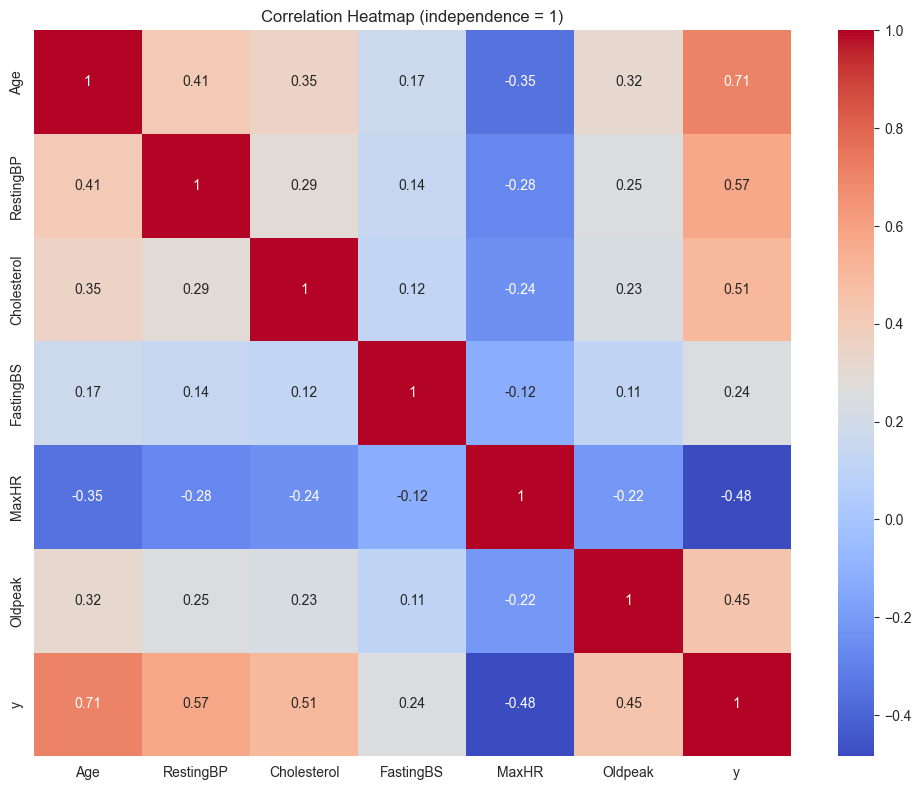

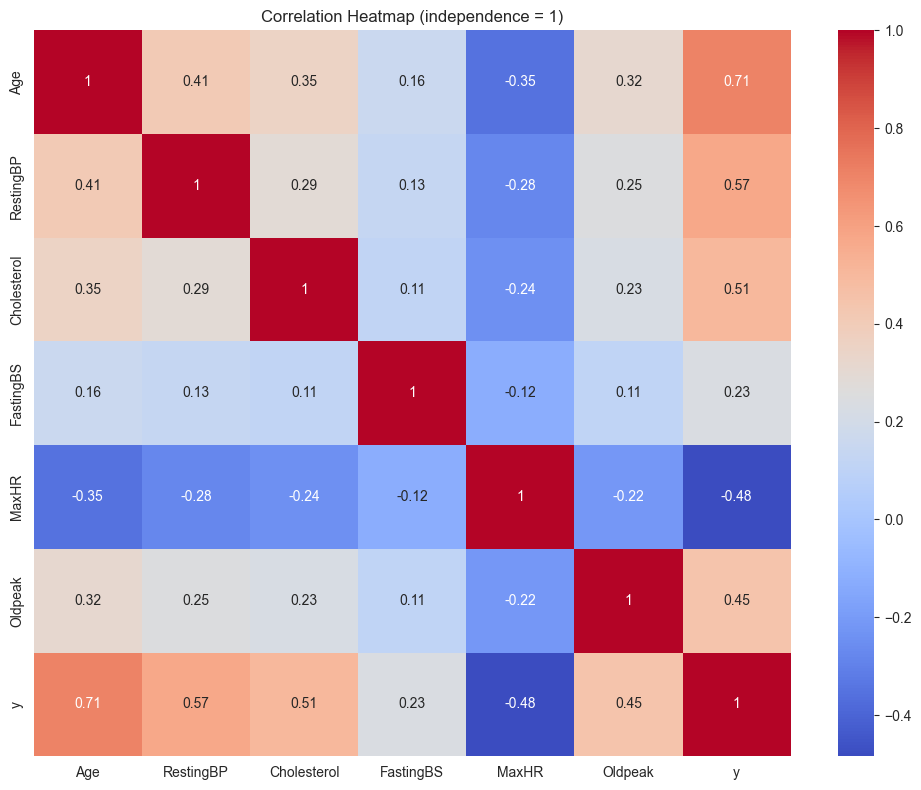

In [8]:
df = generate_synthetic_data(
    n_samples=20000,
    independence=1,
    random_state=42,
)
save_plots(df)
df.to_csv('synthetic_heart_data.csv', index=False)

# Also generate a Naive Bayes friendly dataset variant (adds noise)
df_nb = generate_synthetic_data(
    n_samples=20000,
    random_state=42,
    label_balance=0.5,
    noise_sigma=0.03
)
save_plots(df_nb, out_dir="./plots/generated_nb")
df_nb.to_csv('synthetic_heart_data_gaussian.csv', index=False)

In [9]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB

class MixedNB:
    def __init__(self, continuous_cols, binary_cols):
        self.continuous_cols = continuous_cols
        self.binary_cols = binary_cols
        self.gnb = GaussianNB()
        self.bnb = BernoulliNB()
        self.classes_ = None

    def fit(self, X, y):
        # Identify features based on column names (as prepared by scale_features)
        X_cont = X[self.continuous_cols]
        X_bin = X[[col for col in X.columns if col not in self.continuous_cols]]

        # Fit GaussianNB to continuous features
        self.gnb.fit(X_cont, y)
        # Fit BernoulliNB to binary/one-hot-encoded features
        self.bnb.fit(X_bin, y)
        self.classes_ = self.gnb.classes_
        return self

    def predict(self, X):
        # Predict class by combining log probabilities
        X_cont = X[self.continuous_cols]
        X_bin = X[[col for col in X.columns if col not in self.continuous_cols]]

        # Get log probabilities from each model
        gnb_log_proba = self.gnb.predict_log_proba(X_cont)
        bnb_log_proba = self.bnb.predict_log_proba(X_bin)

        # The combined log-probability is the sum of log-probabilities
        # plus the log-prior (log-prior is only included once, e.g., from GNB)
        # Note: log_proba includes log-prior, so we need to subtract one
        # log-prior from the sum to avoid double-counting it.
        
        # P(y|x) is proportional to P(y) * product(P(xi|y))
        # log(P(y|x)) is proportional to log(P(y)) + sum(log(P(xi|y)))
        # log_proba for GNB is log(P(y)) + sum(log(P(xi_cont|y)))
        # log_proba for BNB is log(P(y)) + sum(log(P(xi_bin|y)))
        # Summing the two is: 2*log(P(y)) + sum(log(P(xi_cont|y))) + sum(log(P(xi_bin|y)))
        # We need to subtract log(P(y)) once to correct:
        
        # Combined log-joint probability (proportional to log posterior)
        combined_log_joint_proba = (gnb_log_proba + bnb_log_proba) - np.log(self.gnb.class_prior_)

        # Predict the class with the highest combined log-probability
        return self.classes_[np.argmax(combined_log_joint_proba, axis=1)]

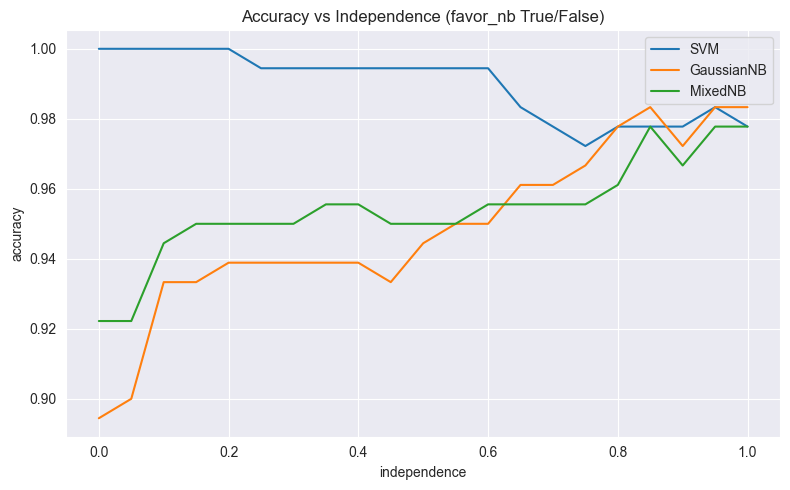

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

samples = 900
independence_steps = np.round(np.arange(0, 1.05, 0.05), 2)
noise_sigma = undefined
random_state = 42

continuous_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Collect accuracies for favor_nb=False and favor_nb=True
accuracy = pd.DataFrame(
    columns=[
        "independence",
        "svm_false", "gaussian_false", "mixed_gaussian_false",
        "svm_true", "gaussian_true", "mixed_gaussian_true"
    ]
)

for independence_step in independence_steps:
    # Dataset with favor_nb=False
    data_false = generate_synthetic_data(
        n_samples=samples,
        independence=independence_step,
        random_state=random_state,
    )
    Xf = scale_features(data_false.loc[:, data_false.columns != 'y'])
    Yf = data_false['y']
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, Yf, test_size=0.2, random_state=random_state)
    
    Xf_cont_cols = [col for col in Xf_train.columns if col in continuous_cols]
    Xf_bin_cols = [col for col in Xf_train.columns if col not in Xf_cont_cols]

    svm_f = SVC(kernel='rbf', random_state=random_state)
    nb_f = GaussianNB()
    mixed_nb_f = MixedNB(continuous_cols=Xf_cont_cols, binary_cols=Xf_bin_cols)
    svm_f.fit(Xf_train, yf_train)
    nb_f.fit(Xf_train, yf_train)
    mixed_nb_f.fit(Xf_train, yf_train)
    acc_svm_f = accuracy_score(yf_test, svm_f.predict(Xf_test))
    acc_nb_f = accuracy_score(yf_test, nb_f.predict(Xf_test))
    acc_mixed_nb_f = accuracy_score(yf_test, mixed_nb_f.predict(Xf_test))

    # Dataset with favor_nb=True
    data_true = generate_synthetic_data(
        n_samples=samples,
        independence=independence_step,
        random_state=random_state,
        noise_sigma=noise_sigma
    )
    Xt = scale_features(data_true.loc[:, data_true.columns != 'y'])
    Yt = data_true['y']
    Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, Yt, test_size=0.2, random_state=random_state)

    Xt_cont_cols = [col for col in Xt_train.columns if col in continuous_cols]
    Xt_bin_cols = [col for col in Xt_train.columns if col not in Xt_cont_cols]

    svm_t = SVC(kernel='rbf', random_state=random_state)
    nb_t = GaussianNB()
    mixed_nb_t = MixedNB(continuous_cols=Xt_cont_cols, binary_cols=Xt_bin_cols)
    svm_t.fit(Xt_train, yt_train)
    nb_t.fit(Xt_train, yt_train)
    mixed_nb_t.fit(Xt_train, yt_train)
    acc_svm_t = accuracy_score(yt_test, svm_t.predict(Xt_test))
    acc_nb_t = accuracy_score(yt_test, nb_t.predict(Xt_test))
    acc_mixed_nb_t = accuracy_score(yt_test, mixed_nb_t.predict(Xt_test))

    accuracy.loc[len(accuracy)] = [
        independence_step,
        acc_svm_f, acc_nb_f, acc_mixed_nb_f,
        acc_svm_t, acc_nb_t, acc_mixed_nb_t
    ]

plt.figure(figsize=(8,5))
plt.plot(accuracy["independence"], accuracy["svm_false"], label="SVM")
plt.plot(accuracy["independence"], accuracy["gaussian_false"], label="GaussianNB")
plt.plot(accuracy["independence"], accuracy["mixed_gaussian_false"], label="MixedNB")
#plt.plot(accuracy["independence"], accuracy["svm_true"], label="SVM (noise_sigma)")
#plt.plot(accuracy["independence"], accuracy["gaussian_true"], label="GaussianNB (noise_sigma)")
plt.xlabel("independence")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs Independence (favor_nb True/False)")
plt.tight_layout()
plt.show()


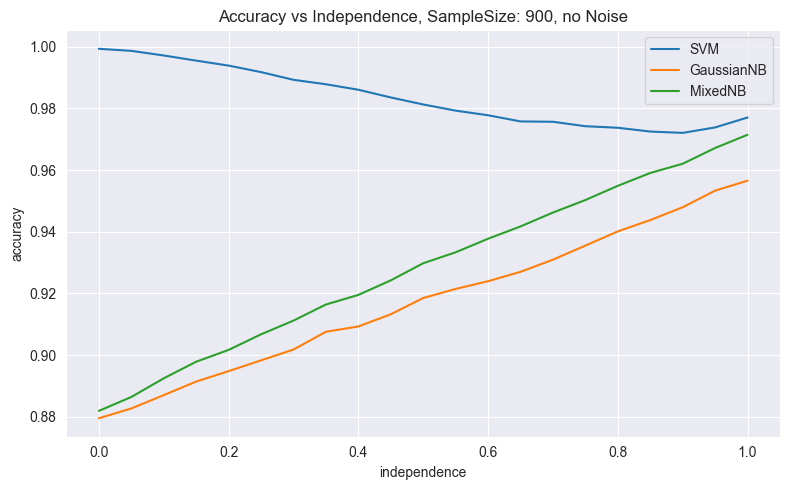

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

samples = 900
independence_steps = np.round(np.arange(0, 1.05, 0.05), 2)
noise_sigma = undefined
random_states = range(1, 101)

continuous_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Collect accuracies for favor_nb=False and favor_nb=True
accuracy = pd.DataFrame(
    columns=[
        "independence",
        "svm_false", "gaussian_false", "mixed_gaussian_false"
    ]
)

for independence_step in independence_steps:

    svm_acc = []
    nb_acc = []
    mixed_nb_acc = []

    for random_state in random_states:
        # Generate Dataset
        data_false = generate_synthetic_data(
            n_samples=samples,
            independence=independence_step,
            random_state=random_state,
            noise_sigma=noise_sigma
        )
        Xf = scale_features(data_false.loc[:, data_false.columns != 'y'])
        Yf = data_false['y']
        Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, Yf, test_size=0.2, random_state=random_state)

        Xf_cont_cols = [col for col in Xf_train.columns if col in continuous_cols]
        Xf_bin_cols = [col for col in Xf_train.columns if col not in Xf_cont_cols]

        # Create Models
        svm_f = SVC(kernel='rbf', random_state=random_state)
        nb_f = GaussianNB()
        mixed_nb_f = MixedNB(continuous_cols=Xf_cont_cols, binary_cols=Xf_bin_cols)

        # Train Models
        svm_f.fit(Xf_train, yf_train)
        nb_f.fit(Xf_train, yf_train)
        mixed_nb_f.fit(Xf_train, yf_train)

        # Save Accuracy
        svm_acc.append(accuracy_score(yf_test, svm_f.predict(Xf_test)))
        nb_acc.append(accuracy_score(yf_test, nb_f.predict(Xf_test)))
        mixed_nb_acc.append(accuracy_score(yf_test, mixed_nb_f.predict(Xf_test)))

    accuracy.loc[len(accuracy)] = [
        independence_step,
        np.mean(svm_acc), np.mean(nb_acc), np.mean(mixed_nb_acc)
    ]

plt.figure(figsize=(8,5))
plt.plot(accuracy["independence"], accuracy["svm_false"], label="SVM")
plt.plot(accuracy["independence"], accuracy["gaussian_false"], label="GaussianNB")
plt.plot(accuracy["independence"], accuracy["mixed_gaussian_false"], label="MixedNB")
plt.xlabel("independence")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs Independence, SampleSize: 900, no Noise")
plt.tight_layout()
plt.show()


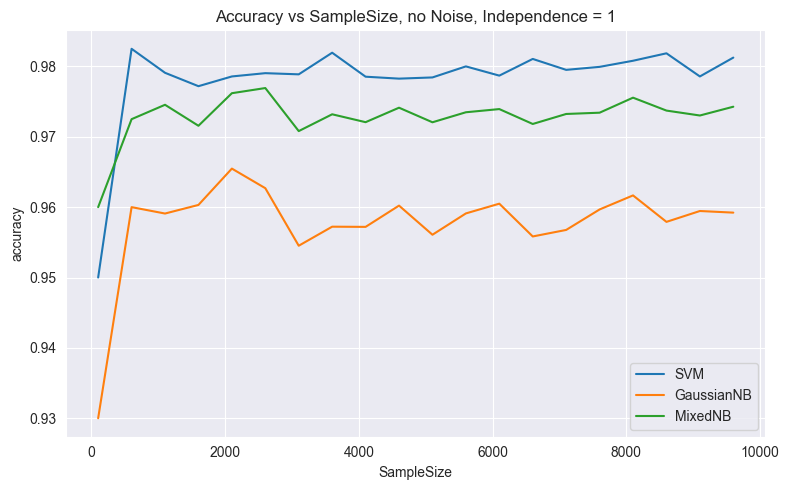

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

sampleList = np.arange(100, 10001, 500)
independence_step = 1
random_states = range(1, 101, 10)

continuous_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

accuracy = pd.DataFrame(
    columns=[
        "sampleSize",
        "svm_false", "gaussian_false", "mixed_gaussian_false"
    ]
)

for samples in sampleList:

    svm_acc = []
    nb_acc = []
    mixed_nb_acc = []

    for random_state in random_states:
        # Generate Dataset
        data_false = generate_synthetic_data(
            n_samples=samples,
            independence=independence_step,
            random_state=random_state
        )
        Xf = scale_features(data_false.loc[:, data_false.columns != 'y'])
        Yf = data_false['y']
        Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, Yf, test_size=0.2, random_state=random_state)

        Xf_cont_cols = [col for col in Xf_train.columns if col in continuous_cols]
        Xf_bin_cols = [col for col in Xf_train.columns if col not in Xf_cont_cols]

        # Create Models
        svm_f = SVC(kernel='rbf', random_state=random_state)
        nb_f = GaussianNB()
        mixed_nb_f = MixedNB(continuous_cols=Xf_cont_cols, binary_cols=Xf_bin_cols)

        # Train Models
        svm_f.fit(Xf_train, yf_train)
        nb_f.fit(Xf_train, yf_train)
        mixed_nb_f.fit(Xf_train, yf_train)

        # Save Accuracy
        svm_acc.append(accuracy_score(yf_test, svm_f.predict(Xf_test)))
        nb_acc.append(accuracy_score(yf_test, nb_f.predict(Xf_test)))
        mixed_nb_acc.append(accuracy_score(yf_test, mixed_nb_f.predict(Xf_test)))

    accuracy.loc[len(accuracy)] = [
        samples,
        np.mean(svm_acc), np.mean(nb_acc), np.mean(mixed_nb_acc)
    ]

plt.figure(figsize=(8,5))
plt.plot(accuracy["sampleSize"], accuracy["svm_false"], label="SVM")
plt.plot(accuracy["sampleSize"], accuracy["gaussian_false"], label="GaussianNB")
plt.plot(accuracy["sampleSize"], accuracy["mixed_gaussian_false"], label="MixedNB")
plt.xlabel("SampleSize")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs SampleSize, no Noise, Independence = 1")
plt.tight_layout()
plt.show()


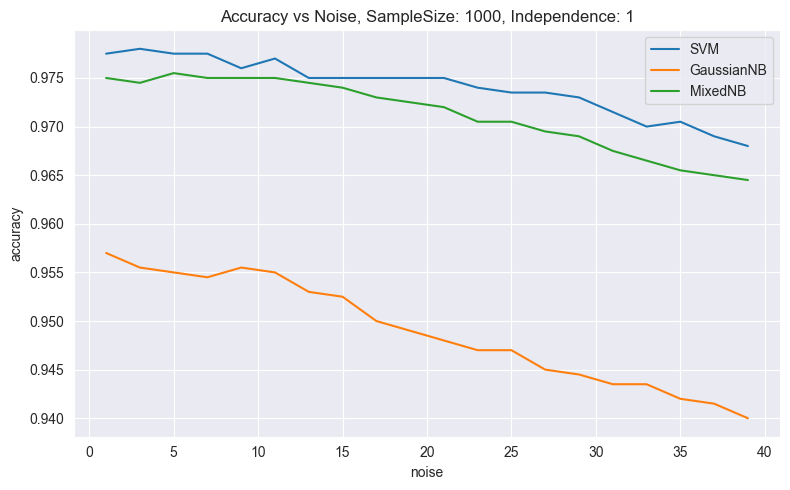

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

samples = 1000
independence_step = 1
noise_sigma_list = np.arange(1, 41, 2)
random_states = range(1, 101, 10)

continuous_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Collect accuracies for favor_nb=False and favor_nb=True
accuracy = pd.DataFrame(
    columns=[
        "noise",
        "svm_false", "gaussian_false", "mixed_gaussian_false"
    ]
)

for noise_sigma in noise_sigma_list:
    svm_acc = []
    nb_acc = []
    mixed_nb_acc = []

    for random_state in random_states:
        # Generate Dataset
        data_false = generate_synthetic_data(
            n_samples=samples,
            independence=independence_step,
            random_state=random_state,
            noise_sigma=noise_sigma
        )
        Xf = scale_features(data_false.loc[:, data_false.columns != 'y'])
        Yf = data_false['y']
        Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, Yf, test_size=0.2, random_state=random_state)

        Xf_cont_cols = [col for col in Xf_train.columns if col in continuous_cols]
        Xf_bin_cols = [col for col in Xf_train.columns if col not in Xf_cont_cols]

        # Create Models
        svm_f = SVC(kernel='rbf', random_state=random_state)
        nb_f = GaussianNB()
        mixed_nb_f = MixedNB(continuous_cols=Xf_cont_cols, binary_cols=Xf_bin_cols)

        # Train Models
        svm_f.fit(Xf_train, yf_train)
        nb_f.fit(Xf_train, yf_train)
        mixed_nb_f.fit(Xf_train, yf_train)

        # Save Accuracy
        svm_acc.append(accuracy_score(yf_test, svm_f.predict(Xf_test)))
        nb_acc.append(accuracy_score(yf_test, nb_f.predict(Xf_test)))
        mixed_nb_acc.append(accuracy_score(yf_test, mixed_nb_f.predict(Xf_test)))

    accuracy.loc[len(accuracy)] = [
        noise_sigma,
        np.mean(svm_acc), np.mean(nb_acc), np.mean(mixed_nb_acc)
    ]

plt.figure(figsize=(8,5))
plt.plot(accuracy["noise"], accuracy["svm_false"], label="SVM")
plt.plot(accuracy["noise"], accuracy["gaussian_false"], label="GaussianNB")
plt.plot(accuracy["noise"], accuracy["mixed_gaussian_false"], label="MixedNB")
plt.xlabel("noise")
plt.ylabel("accuracy")
plt.legend()
plt.title("Accuracy vs Noise, SampleSize: 1000, Independence: 1")
plt.tight_layout()
plt.show()
